In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
# import seaborn as sns
from matplotlib.pyplot import MultipleLocator
from matplotlib import rcParams
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import expm
from numba import jit,njit
from numpy.linalg import eig


In [3]:
J = 1
d = 0.1
MU_list = np.arange(-1.5, 1.5, 0.05)

delta_list = np.arange(-0.6,0.6, 0.05)
Delta = 2.0
@jit()
def Hamiltonian_single(k,mu,delta,Delta):
    H = np.zeros((4, 4), dtype=complex)
    eta = (Delta-delta)-(Delta+delta)*np.exp(1j*k)
    gamma = J+J*np.exp(1j*k)
    rows = [0, 1]
    cols = [0, 1]
    H[rows,cols] = -2*mu
    H[0,1] = gamma.conj()
    H[1,0] = gamma
    rows = [2, 3]
    cols = [2, 3]
    H[rows,cols] = 2*mu
    H[2,3] = -gamma.conj()
    H[3,2] = -gamma

    H[0,3] =  - np.exp(-1j*k)*eta
    H[1,2] =   np.exp(1j*k)*eta.conj()
    H[2,1] = - eta.conj()
    H[3,0] = eta

    return H
@jit()
def Hamiltonian(k, mu, delta, Delta):
    H = np.zeros((6, 6), dtype=np.complex128)

    eta = (Delta - delta) - (Delta + delta) * np.exp(1j * k)
    gamma = J + J * np.exp(1j * k)

    for r, c in zip([2, 3, 4, 4], [1, 1, 2, 3]):
        H[r, c] = gamma
    for r, c in zip([1, 1, 2, 3], [2, 3, 4, 4]):
        H[r, c] = np.conj(gamma)

    for i in [1, 2, 3, 4]:
        H[i, i] = -4 * mu
    H[5, 5] = -8 * mu

    H[0, 1] = eta
    H[1, 0] = -eta * np.exp(-1j * k)

    H[0, 4] = -np.conj(eta)
    H[4, 0] = np.conj(eta) * np.exp(1j * k)

    H[1, 5] = -np.conj(eta)
    H[5, 1] = np.conj(eta) * np.exp(1j * k)

    H[4, 5] = eta
    H[5, 4] = -np.exp(-1j * k) * eta

    return H

@jit()
def order_parameter_1(k):
    H = np.zeros((6, 6), dtype=np.complex128)
    H[1,0] = 1j
    H[5,4 ] = 1j
    H[0,1] = -1j
    H[4,5] = -1j
    return H

@jit()
def order_parameter_2(k):
    H = np.zeros((6, 6), dtype=np.complex128)
    H[2,0] = 1j
    H[5,3 ] = 1j
    H[0,2] = -1j
    H[3,5 ] = -1j
    return H
@jit()
def order_parameter_3(k):
    H = np.zeros((6, 6), dtype=np.complex128)
    H[3,0] = 1j
    H[5,2 ] = 1j
    H[0,3] = -1j
    H[2,5 ] = -1j
    return H
@jit()
def order_parameter_4(k):
    H = np.zeros((6, 6), dtype=np.complex128)
    H[4,0] = 1j
    H[5,1 ] = 1j
    H[0,4] = -1j
    H[1,5 ] = -1j
    return H


@jit()
def Order_P(k_list,mu,delta,Delta,t):
    value = 0
    for i, k in enumerate(k_list):
        psi_t = np.zeros((6, 1), dtype=np.complex128)
        psi_t[0,0] = 1
        H = Hamiltonian(k,mu,delta,Delta)
        Order_P_1 = order_parameter_1(k)
        Order_P_2 = order_parameter_2(k)
        Order_P_3 = order_parameter_3(k)
        Order_P_4 = order_parameter_4(k)
        E, V = eig(H)  
        U = V .dot( np.diag(np.exp(-1j * E * t)).dot( np.conj(V).T))
        psi_t = U.dot(psi_t)
        psi_t /= np.sqrt(np.dot(np.conj(psi_t).T,psi_t))
        value += np.abs((np.conj(psi_t).T.dot(Order_P_1.dot(psi_t))).item())
        value += np.abs((np.conj(psi_t).T.dot(Order_P_2.dot(psi_t))).item())
        value += np.abs((np.conj(psi_t).T.dot(Order_P_3.dot(psi_t))).item())
        value += np.abs((np.conj(psi_t).T.dot(Order_P_4.dot(psi_t))).item())

    value /= len(k_list)
    return value


N = 100
kappa = 0
k_list = np.arange(2 * np.pi / N, np.pi - 2 * np.pi / N, 2*np.pi/N)
time_list = np.linspace(0,100,1000)







value_buffer = np.zeros((len(MU_list),len(delta_list),len(time_list)))
for zz, mu in enumerate(MU_list):
    for yy, delta in enumerate(delta_list):
        for xx, t in enumerate(time_list):
    
            value_buffer[zz,yy,xx] = Order_P(k_list,mu,delta,Delta,t)

value_buffer

array([[[1.01740457, 0.99599211, 0.98475199, ..., 1.03849   ,
         1.06653367, 1.08470426],
        [0.91434831, 0.96581545, 1.01153986, ..., 1.15965739,
         1.12794563, 1.10721858],
        [0.79009676, 0.93236505, 1.02085577, ..., 1.14092108,
         1.06429188, 1.03446789],
        ...,
        [0.51727513, 0.69089434, 0.76233568, ..., 1.08417378,
         1.10447953, 1.02777918],
        [0.57367491, 0.67641535, 0.72788742, ..., 0.96210376,
         0.93269977, 0.89003949],
        [0.65808533, 0.67820512, 0.68128455, ..., 0.9206218 ,
         0.9196547 , 0.873507  ]],

       [[1.07548019, 1.02235479, 0.96812321, ..., 1.15926317,
         1.1507837 , 1.19062842],
        [0.94406755, 0.97689344, 1.00157536, ..., 1.14900963,
         1.13706166, 1.21179844],
        [0.82499417, 0.94480764, 1.02886793, ..., 1.19675142,
         1.1565902 , 1.12726164],
        ...,
        [0.53920913, 0.69157862, 0.76395263, ..., 0.97305735,
         0.94817084, 1.01367635],
        [0.6

In [4]:
Average_order_parameter = np.zeros((len(MU_list),len(delta_list)))

Average_order_parameter = np.sum(value_buffer[:,:,len(time_list)//4:],axis=2)/len(time_list)/2
np.savez('fig4.npz', order_parameter=value_buffer, Average_order_parameter=Average_order_parameter)

In [244]:
Average_order_parameter

array([[0.41213472, 0.41672475, 0.41784187, 0.41628456, 0.41316562,
        0.40842449, 0.40261844, 0.39598579, 0.3889016 , 0.3813287 ,
        0.37269722, 0.36213725],
       [0.40648485, 0.41396326, 0.41713834, 0.41765301, 0.4153375 ,
        0.41114525, 0.40528829, 0.39824603, 0.39024978, 0.38127689,
        0.37073584, 0.35676323],
       [0.39186386, 0.40570067, 0.41265619, 0.41451574, 0.413236  ,
        0.4093896 , 0.40347107, 0.39572722, 0.38678379, 0.37628258,
        0.36378206, 0.34599938],
       [0.36651293, 0.3874786 , 0.3997228 , 0.40480852, 0.40544706,
        0.40232063, 0.39639429, 0.38783201, 0.3771168 , 0.36404774,
        0.34694325, 0.32267384],
       [0.37747811, 0.35767939, 0.37165123, 0.38208748, 0.38533611,
        0.38285039, 0.37674482, 0.36703417, 0.35449221, 0.33781708,
        0.31468855, 0.28719458],
       [0.35843836, 0.35203263, 0.35929089, 0.35666167, 0.34937125,
        0.3365036 , 0.326858  , 0.31880265, 0.31524097, 0.30875758,
        0.29800349,

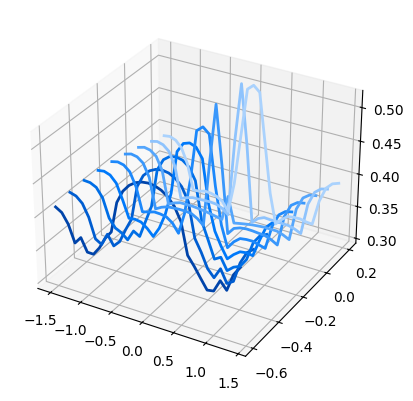

In [245]:

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

C = ['#0044aa', '#005dd1', '#006ee6',
     '#0079fa', '#1c88fb', '#3997fb',
     '#55a6fc', '#8ec3fd', '#aad2fd']

for i in range(9):  # 颜色只有6种，必须用 range(6)
    x = MU_list[:]  # X 轴
    y = delta_list[i] * np.ones_like(MU_list)  # Y 轴（常数平面）
    z = Average_order_parameter[:, i]  # Z 轴（观测值）

    ax.plot(x, y, z, lw=2, c = C[i])


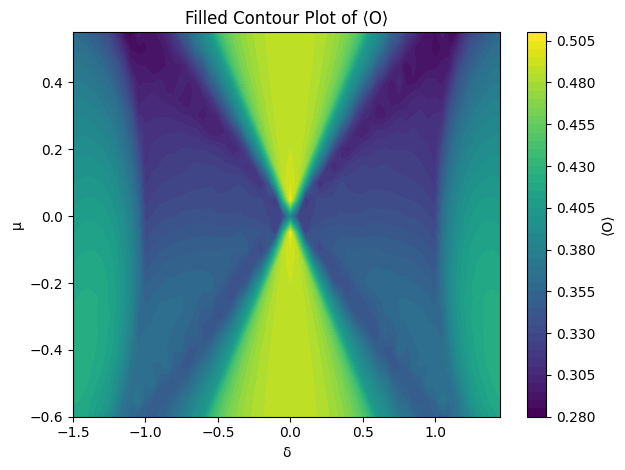

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 示例数据
x = MU_list   # μ轴
y = delta_list  # δ轴
X, Y = np.meshgrid(x, y)
Z = Average_order_parameter.T  # 示例 order parameter

plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='⟨O⟩')
plt.xlabel('δ')
plt.ylabel('μ')
plt.title('Filled Contour Plot of ⟨O⟩')
plt.tight_layout()
plt.show()

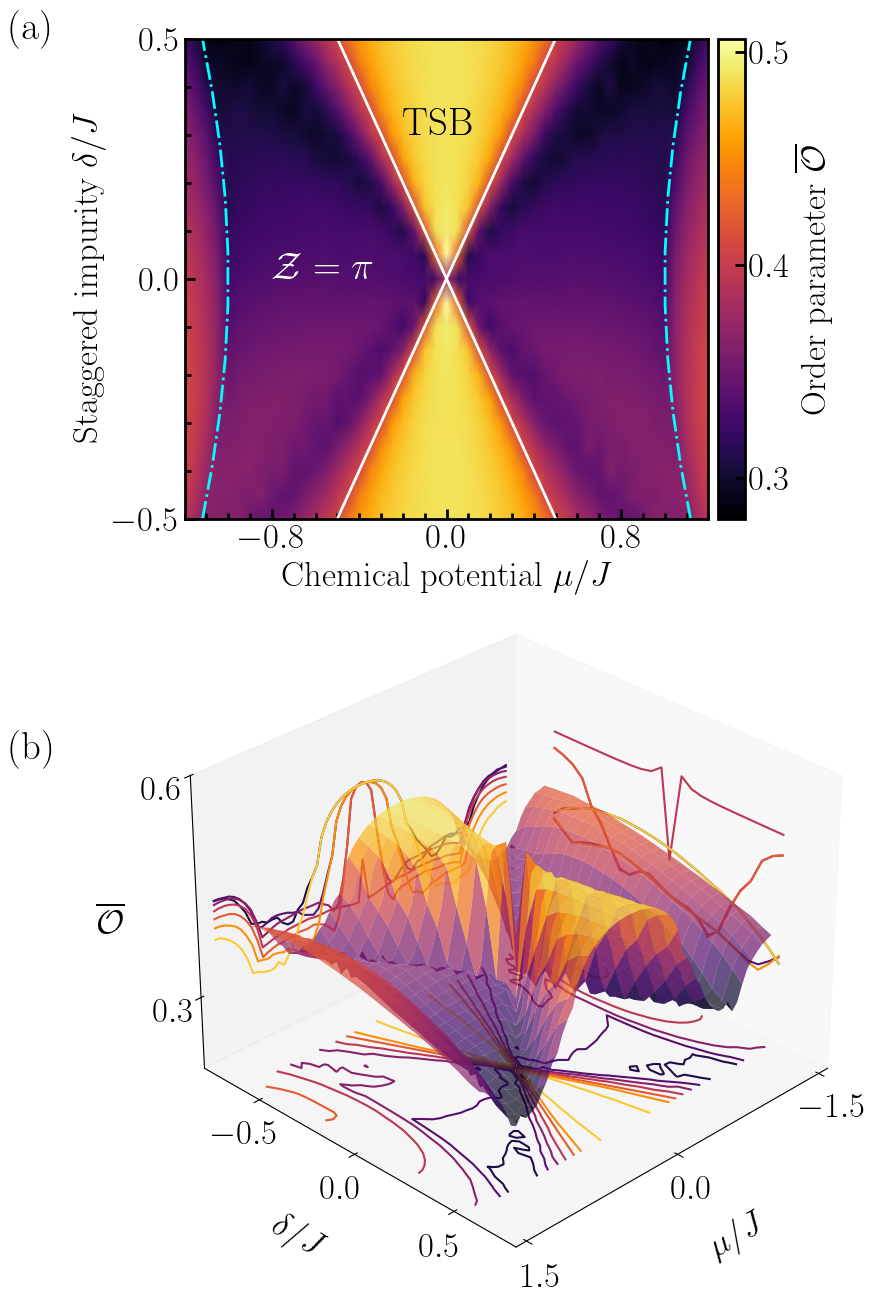

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from matplotlib.colors import rgb2hex  # 正确导入 rgb2hex
from matplotlib.cm import plasma  # 直接导入 plasma 色条
from matplotlib.colors import Normalize
# Load data

from matplotlib import cm
# MU_list = np.arange(-1.5, 1.5, 0.05)
# delta_list = np.arange(-0.6, 0.6, 0.05)
AA = np.load('fig4.npz')
x = MU_list   # μ axis
y = delta_list  # δ axis
X, Y = np.meshgrid(x, y)
Z = AA['Average_order_parameter']

# Set up figure
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "text.latex.preamble": r"\usepackage{amsmath}"
})

font_size = 25
fig = plt.figure(figsize=(7, 16))

ax1 = fig.add_axes([0.0,0.0,1.0,0.48],projection='3d') 

ax2 = fig.add_axes([0.04,0.5,0.8,0.3])
# First subplot - 3D plot


# 生成12个均匀分布的颜色（0到1之间）
cmap = plt.get_cmap('viridis')  
hex_colors = [rgb2hex(cmap(i)) for i in np.linspace(0, 0.9, 12)]  # 避免最亮色重复



C = ['#0079fa','#1c88fb','#3997fb','#55a6fc','#8ec3fd','#aad2fd']


x_vals = MU_list[:]
y_vals = delta_list[:]

 
X, Y = np.meshgrid(x_vals, y_vals)
ax1.plot_surface(X, Y, Z.T, 
                 cmap=cm.inferno, 
                 shade=True, 
                 alpha=0.7, 
                 antialiased=True,  # 改为 True
                #  shading='gouraud',  # 添加这一行（比默认的 'flat' 更平滑）
                 linewidth=0,
                 vmax=Z.max(),vmin=Z.min()
                 )



ax1.zaxis.set_rotate_label(False)
ax1.contour(X, Y, Z.T, zdir='z', offset=0.2, cmap=cm.inferno)
ax1.contour(X, Y, Z.T, zdir='x', offset=-1.6, cmap=cm.inferno)
ax1.contour(X, Y, Z.T, zdir='y', offset=-0.8, cmap=cm.inferno)
ax1.set(xlim=(-1.6,1.6), ylim=(-0.8,0.8), zlim=(0.2,0.6))
ax1.view_init(elev=30,azim=210)
ax1.tick_params(labelsize=font_size)
ax1.grid(False)

ax1.set_xlabel(' $\mu/J$', size=font_size, labelpad=25)
ax1.set_ylabel('$\delta/J$', size=font_size, labelpad=25)
ax1.set_zlabel('$\overline{\mathcal{O}}$', size=font_size, labelpad=15)
ax1.tick_params(which='major', direction='in', length=7, width=2, labelsize=font_size)
ax1.xaxis.set_major_locator(MultipleLocator(1.5))
ax1.yaxis.set_major_locator(MultipleLocator(0.5))
ax1.zaxis.set_major_locator(MultipleLocator(0.3))
ax1.view_init(elev=30, azim=45)  # 设置视角



plasma_cmap = plt.cm.plasma
pcm = ax2.pcolormesh(X, Y, Z.T, cmap=cm.inferno, shading='gouraud',vmax=Z.max(),vmin=Z.min())

# Create colorbar
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(pcm, cax=cax)
cbar.set_label(r'Order parameter $\overline{\mathcal{O}} $', fontsize=font_size)

# Set colorbar style
cbar.ax.tick_params(which='major', direction='in', length=7, width=2, labelsize=font_size)
cbar.ax.tick_params(which='minor', direction='in', length=4, width=2)
for spine in cbar.ax.spines.values():
    spine.set_linewidth(2)
# cbar.ax.set_ylim([0, 1])
cbar.ax.yaxis.set_major_locator(MultipleLocator(0.1))
# Set main plot format
ax2.tick_params(which='minor', direction='in', length=4, width=2)
ax2.tick_params(which='major', direction='in', length=7, width=2, labelsize=font_size)
ax2.set_ylabel('Staggered impurity $\delta/ J$', size=font_size)
ax2.set_xlabel('Chemical potential $\mu/J$', size=font_size)
ax2.xaxis.set_minor_locator(MultipleLocator(0.1))
ax2.xaxis.set_major_locator(MultipleLocator(0.8))
ax2.yaxis.set_minor_locator(MultipleLocator(0.1))
ax2.yaxis.set_major_locator(MultipleLocator(0.5))
for side in ['bottom', 'top', 'right', 'left']:
    ax2.spines[side].set_linewidth(2)

ax2.set_ylim([-0.5, 0.5])
ax2.set_xlim([-1.2, 1.2])

XX = np.linspace(-0.5,0.5,10)
YY_1 = XX

YY_2 = np.sqrt(1+XX**2)
YY_3 = np.sqrt(1+XX**2)

ax2.plot(YY_1,XX,c = [1,1,1],lw = 2)
ax2.plot(-YY_1,XX,c = [1,1,1],lw = 2)
ax2.plot(YY_2,XX,c = [0,1,1],lw = 2,ls = '-.')
ax2.plot(-YY_2,XX,c = [0,1,1],lw = 2,ls = '-.')
ax2.text(-2.,-1.0,'(b)', fontsize=font_size + 3)
ax2.text(-2. , 0.5, '(a)', fontsize=font_size + 3)

ax2.text(-0.2 , 0.3, 'TSB', fontsize=font_size + 3)
ax2.text(-0.8 , 0.0, r'$\mathcal{Z} = \pi $', fontsize=font_size + 3,c = 'white')
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.6)
plt.savefig('fig4.pdf',transparent = True,bbox_inches = 'tight')



In [86]:
np.shape(Z[i+1, :])

(12,)